In [606]:
from torchvision import models
import numpy as np
import cv2
import PIL

from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

import torch
import torchvision.transforms as transforms


In [607]:
# class ModifiedResNet50(models.ResNet):
#     def __init__(self):
#         super(ModifiedResNet50, self).__init__(models.resnet.Bottleneck, [3, 4, 6, 3])
#         self.fc = torch.nn.Linear(2048, 2)  # Modify the final fully connected layer for your specific task

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)  # Pass through the modified fully connected layer
#         return x

# # Create the modified model instance
# model = ModifiedResNet50()
# model.eval()

In [608]:
def check_img(img):
        print(img.dtype)

        if np.min(img) < 0 or np.max(img) > 1:
                print("Values are not in the range [0, 1]")
                min_value = np.min(img)
                max_value = np.max(img)

                print("Minimum pixel value:", min_value)
                print("Maximum pixel value:", max_value)

        else:
                print("Image is valid") 

In [609]:
def predicted_class_ckeck(img, model, arr):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to match ResNet's input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

    # Feed the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)

    # Apply softmax to get class probabilities
    probs = torch.softmax(logits, dim=1)

    # Get the predicted class label
    pred_class = torch.argmax(probs, dim=1).item()
    print("Predicted class:", pred_class)
    return arr.append(pred_class)

In [610]:
# use the pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [611]:
# fix target class label (of the Imagenet class of interest!)
# 1: goldfish, 250: Siberian Husky, 947: mushroom

# targets = [ClassifierOutputTarget(<target-class-number>)] 
targets = [ClassifierOutputTarget(1)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

In [612]:
# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class

# Preprocess input image, get the input image tensor
# img = np.array(PIL.Image.open('/Users/liviamurray/552_ALproj/800px-Common_goldfish.JPG'))
# img = np.array(PIL.Image.open('/Users/liviamurray/552_ALproj/goldfish2.jpeg'))
img = np.array(PIL.Image.open('/Users/liviamurray/552_ALproj/goldfish-photo.jpg'))


img = cv2.resize(img, (300,300))
img = np.float32(img) / 255
img_noise = img.copy()
img_gauss = img.copy()
img_show = img.copy()

In [613]:
input_tensor = preprocess_image(img_show)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(img_show, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


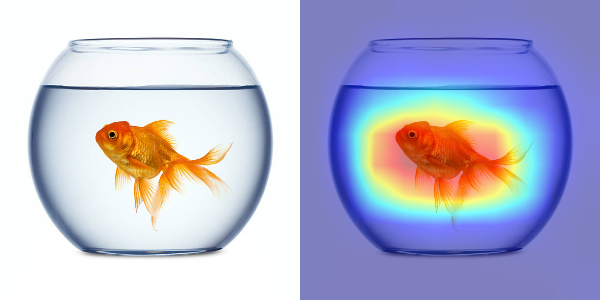

In [614]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img_show), cam_image))
PIL.Image.fromarray(images)

## Schizophrenia

In [615]:
model = models.resnet50(pretrained=True)
model.eval()

# Modify the fully connected layer for your specific task
num_classes = 2  # Modify this based on your classification task
model.fc = torch.nn.Linear(2048, num_classes)

In [616]:
# fix target class label (of the Imagenet class of interest!)
# 1: goldfish, 250: Siberian Husky, 947: mushroom

# targets = [ClassifierOutputTarget(<target-class-number>)] 
targets = [ClassifierOutputTarget(1)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

In [617]:
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class
input_tensor = preprocess_image(img_show)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(img_show, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

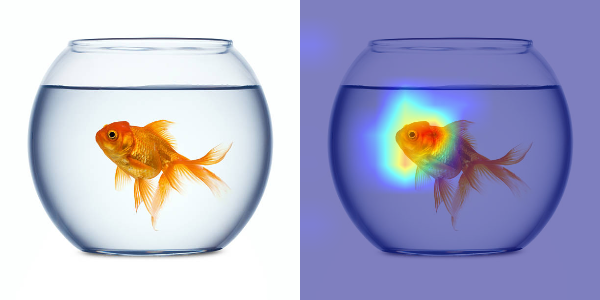

In [618]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img_show), cam_image))
PIL.Image.fromarray(images)

## Gaussian Blur

In [619]:
# cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class

In [620]:
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class
# Define the location and size of the region to apply the blur
x, y, w, h = (100, 100, 50, 50)  # Example: x and y are the coordinates of the top-left corner, w and h are the width and height

# Apply Gaussian blur to the entire image
blurred_img = cv2.GaussianBlur(img_gauss, (25, 25), 0)  # Adjust the kernel size for desired blur intensity

# Create a mask for the square region (all zeros except for the square region which is filled with ones)
mask = np.zeros_like(img_gauss)
mask[y:y+h, x:x+w] = 255

# Replace the blurred area with the original square region using the mask
result_img = np.where(mask == 255, img_gauss, blurred_img)
img_gauss = result_img

In [621]:
input_tensor2 = preprocess_image(img_gauss)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor2, targets=targets)
cam_image = show_cam_on_image(img_gauss, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

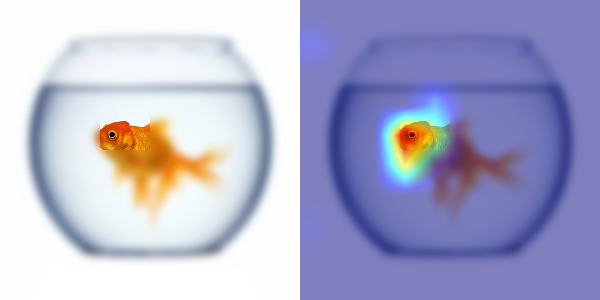

In [622]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img_gauss), cam_image))
PIL.Image.fromarray(images)

In [623]:
check_img(img_gauss)

float32
Image is valid


## Color:

In [624]:
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class

# # Split the image into its RGB channels
b, g, r = cv2.split(img)

# Decrease intensity of the red channel
r = cv2.add(r, 0.4)  # Add 1 to the red channel values

# Clip pixel values to ensure they stay within the range [0, 255]
r = np.clip(r, 0, 1)

# Merge the channels back together
img_color = cv2.merge((b, g, r))


In [625]:
check_img(img_color)

float32
Image is valid


In [626]:
input_tensor4 = preprocess_image(img_color)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor2, targets=targets)

cam_image = show_cam_on_image(img_color, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])

cam = cv2.merge([cam, cam, cam])

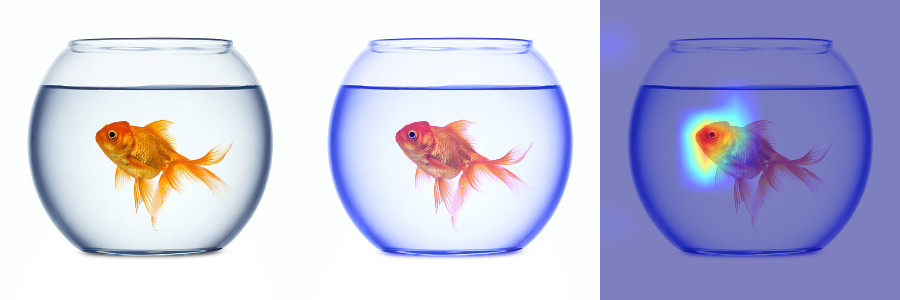

In [627]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img_show), np.uint8(255*img_color), cam_image))
PIL.Image.fromarray(images)